# Generative models

In [94]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

Kullback-Leibner divergence

- $Kl(Q(x) || P(x)) = E_{x \sim Q}[\log Q(x) - \log P(x)]$
- measures how close $Q$ is to $P$
- can be used as a regularizer to ensure that a learned approximate model $Q$ is encouraged to be close to some prior $P$

(tensor(177.1359), tensor(177.1359))

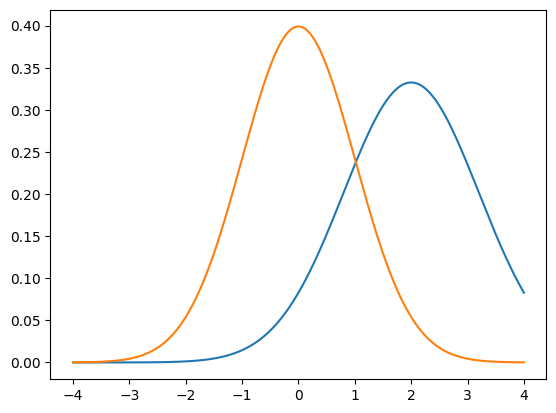

In [3]:
gaussian = lambda x, mu, sigma: 1/(sigma * (2*torch.pi)**0.5) * torch.exp(-.5 * (x-mu)**2 / sigma**2)

x = torch.linspace(-4, 4, 1000)

p = gaussian(x, 2, 1.2)
q = gaussian(x, 0, 1)

plt.plot(x, p)
plt.plot(x, q)

# kl(q || p) = sum q(x) (log q(x) - log p(x))
kl = torch.sum(q * (torch.log(q) - torch.log(p)))

# pytorch: input is p(x) in log-space and target is q(x)
kl, F.kl_div(torch.log(p), q, reduction='sum')

## Standard auto-encoder

Latent space is **not** probabilistic.  

Input to encoder has shape (batch_size, channels, H, W). For MNIST, we resize to $32 \times 32$ images and encode sequentially:
- (batch_size, 1, 32, 32) 
- (batch_size, 64, 16, 16) 
- (batch_size, 128, 8, 8) 
- (batch_size, 256, 4, 4)  
- (batch_size, h_size, 1, 1)

Input to decoder has shape (batch_size, h_size, 1, 1). Sequential decoding until images are $32 \times 32$:
- (batch_size, h_size, 1, 1)
- (batch_size, 256, 4, 4)
- (batch_size, 128, 8, 8)
- (batch_size, 64, 16, 16)
- (batch_size, 1, 32, 32)

In [7]:
class Encoder(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.net = nn.Sequential(
            # 32 -> 16
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 16 -> 8
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            # 8 -> 4
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            # 4 -> 1
            nn.Conv2d(256, z_size, kernel_size=3, stride=2, padding=0, bias=False),
        )
    
    def forward(self, X: torch.Tensor):
        return self.net(X)

class Decoder(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.net = nn.Sequential(
            # 1 -> 4
            nn.ConvTranspose2d(z_size, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            # 4 -> 8
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            # 8 -> 16
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 16 -> 32
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
        )

    def forward(self, X: torch.Tensor):
        return self.net(X)
    
    
class AutoEncoder(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.enc = Encoder(z_size)
        self.dec = Decoder(z_size)

    def forward(self, X: torch.Tensor):
        z = self.enc(X)
        y = self.dec(z)
        return y, z

x = torch.randn(64, 1, 32, 32)
generator = AutoEncoder(z_size=20)
y, z = generator(x)
y.shape, z.shape

(torch.Size([64, 1, 32, 32]), torch.Size([64, 20, 1, 1]))

### Training auto-encoder

In [578]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(32),
    # transforms.Normalize((0.5,), (0.5,)),
    transforms.ToTensor(),
])

train_set = torchvision.datasets.MNIST(root="../datasets", train=True, download=True, transform=transform)

test_val_set = torchvision.datasets.MNIST(root="../datasets", train=False, download=True, transform=transform)
X_test_val, y_test_val = zip(*test_val_set)
X_test_val = torch.stack(X_test_val)
y_test_val = torch.tensor(y_test_val)

test_idx, val_idx = torch.utils.data.random_split(y_test_val, [5000, 5000])

X_test = X_test_val[test_idx.indices]
y_test = y_test_val[test_idx.indices]

X_val = X_test_val[val_idx.indices]
y_val = y_test_val[val_idx.indices]

(train_set.data.shape, train_set.targets.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([5000, 1, 32, 32]),
 torch.Size([5000]),
 torch.Size([5000, 1, 32, 32]),
 torch.Size([5000]))

In [579]:
EPOCHS = 20

train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)

generator = AutoEncoder(z_size=2).to('cuda')

optimizer = torch.optim.Adam(generator.parameters(), lr=0.03)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
criterion = nn.BCEWithLogitsLoss()

train_history = []
val_history = []

for epoch in range(EPOCHS):
    batch_history = []
    for i, (images, _) in enumerate(train_loader):
        images = images.to('cuda')
        # predict and compute loss
        preds, _ = generator(images)
        loss = criterion(preds, images)
        batch_history.append(loss.item())
        # optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # update learning rate
    scheduler.step()
    
    train_history.append(torch.mean(torch.tensor(batch_history)))

    with torch.no_grad():
        preds, _ = generator(X_val.to('cuda'))
        loss = criterion(preds, X_val.to('cuda'))
        val_history.append(loss.item())
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")

with torch.no_grad():
    preds, z = generator(X_test.to('cuda'))
    loss = criterion(preds, X_test.to('cuda'))
    print(f"test_loss {loss.item()}")

epoch 0, train_loss 0.2586672008037567, val_loss 0.22135668992996216
epoch 1, train_loss 0.21317587792873383, val_loss 0.2098037600517273
epoch 2, train_loss 0.20535460114479065, val_loss 0.20558768510818481
epoch 3, train_loss 0.20232611894607544, val_loss 0.2014653980731964
epoch 4, train_loss 0.19941477477550507, val_loss 0.19877414405345917
epoch 5, train_loss 0.19823959469795227, val_loss 0.19933900237083435
epoch 6, train_loss 0.19637486338615417, val_loss 0.19815316796302795
epoch 7, train_loss 0.19515471160411835, val_loss 0.19493751227855682
epoch 8, train_loss 0.1938963234424591, val_loss 0.19596755504608154
epoch 9, train_loss 0.1930449903011322, val_loss 0.19356344640254974
epoch 10, train_loss 0.19175763428211212, val_loss 0.19419150054454803
epoch 11, train_loss 0.19097767770290375, val_loss 0.19338281452655792
epoch 12, train_loss 0.19033832848072052, val_loss 0.19279535114765167
epoch 13, train_loss 0.1892854869365692, val_loss 0.1918104737997055
epoch 14, train_loss 0.

### Visualize training procedure and latent $z$-space

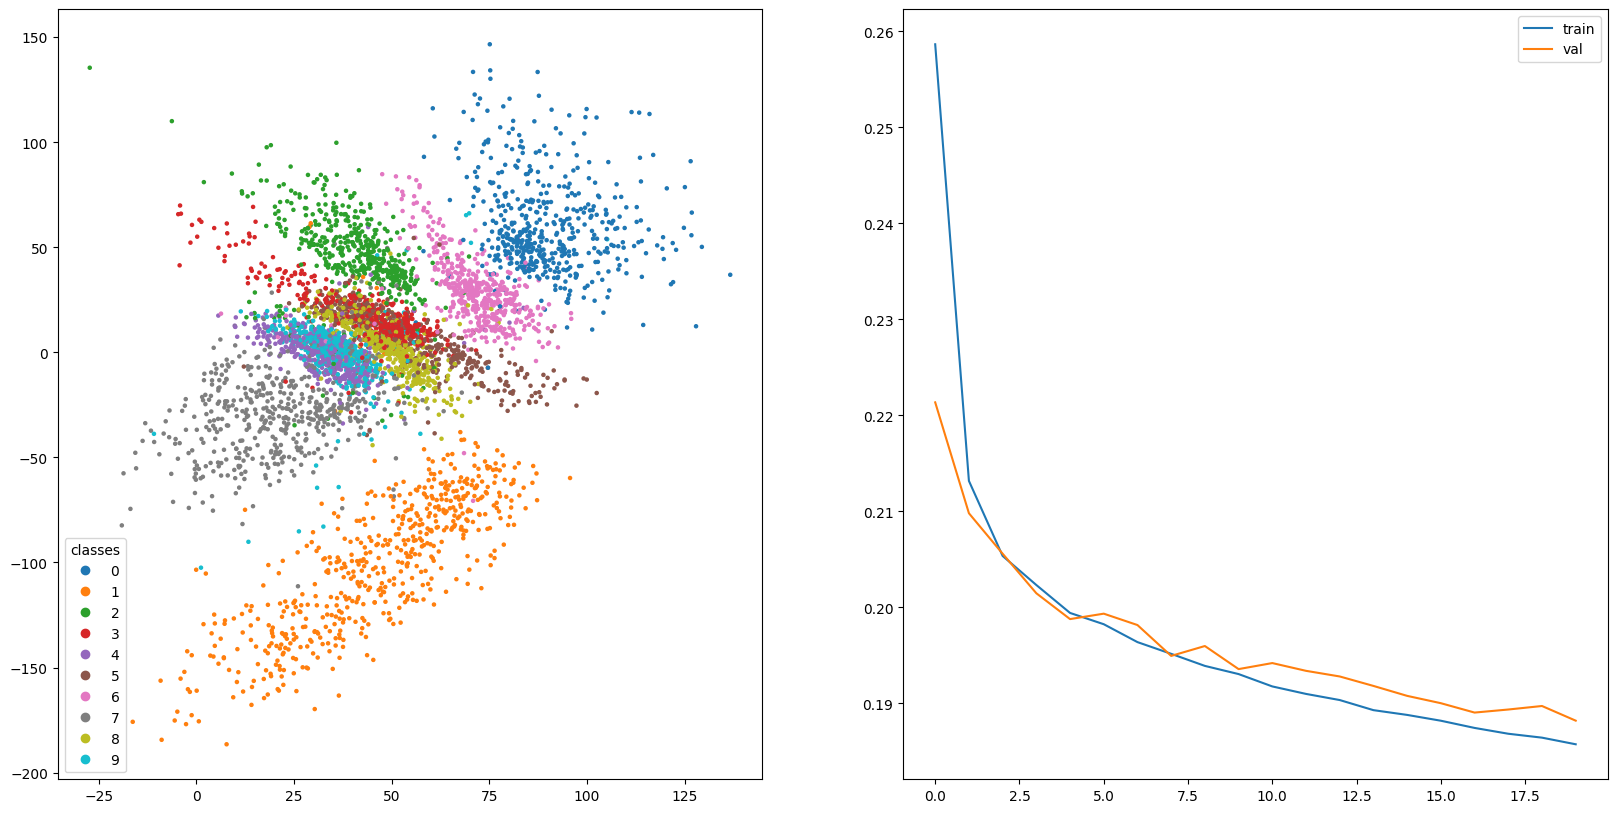

In [580]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

z = z.squeeze().cpu().detach()
sc = ax1.scatter(z[:, 0], z[:, 1], c=y_test, s=5, cmap='tab10')
ax1.legend(*sc.legend_elements(), title='classes')

ax2.plot(train_history, label="train")
ax2.plot(val_history, label="val")
ax2.legend()

### Generating samples

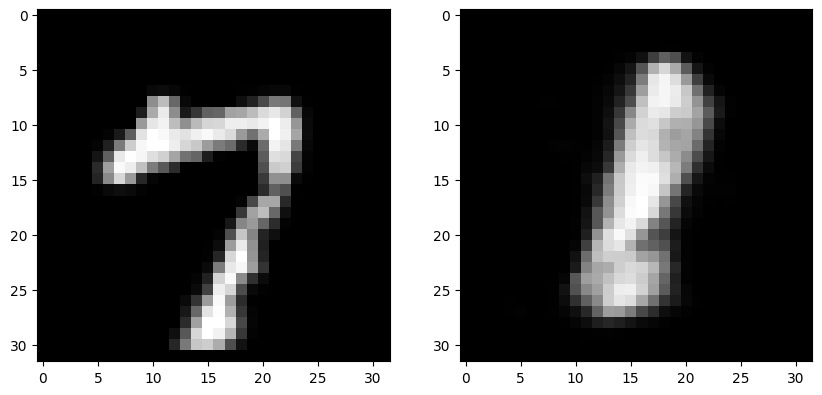

In [581]:
idx = 100

y_pred, _ = generator(X_test[idx][None, :].to('cuda'))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(X_test[idx][None, :].squeeze(), cmap='gray')
ax2.imshow(F.sigmoid(y_pred).cpu().squeeze().detach(), cmap='gray')
plt.show()

Interpolating in the latent space

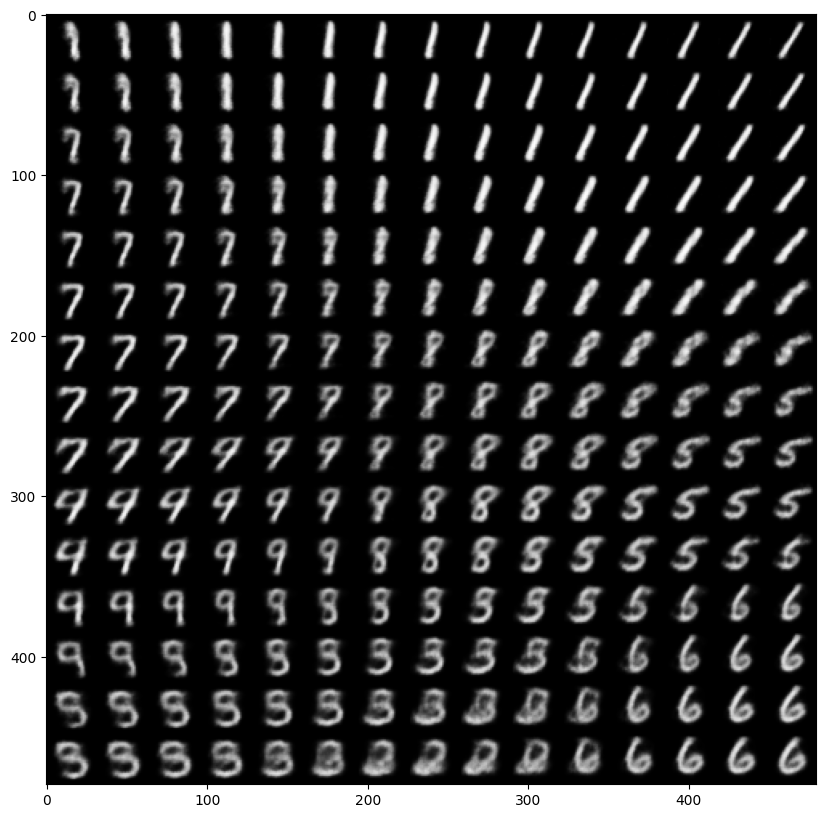

In [582]:
h, w = 15, 15
z1_range = torch.linspace(25, 75, h)
z2_range = torch.linspace(-75, 25, w)

z1, z2 = torch.meshgrid(z1_range, z2_range)
zz = torch.stack([z1, z2], dim=-1).reshape(-1, 2, 1, 1).to('cuda')

y_preds = F.sigmoid(generator.dec(zz)).squeeze().cpu().detach()
y_preds = y_preds.reshape(h, w, 32, 32).permute(1, 2, 0, 3).reshape(h*32, -1)

plt.figure(figsize=(10, 10))
plt.imshow(y_preds, cmap='gray')

## Variational Auto-Encoder

- Same idea as the standard auto-encoder, only the latent $z$-space is defined probabilistically
- **reparameterization trick**: 
    - if we use $\text{z} \sim \mathcal{N}(\mu, \sigma^2)$, the Gaussian parameters $\mu, \sigma$ are not differentiable
    - instead, we let the **randomness** come from an external source $\epsilon \sim \mathcal{N}(0, I)$
    - then, we reparameterize via $\text{z} = \mu + \sigma^2 \epsilon$
    - this way, $\mu$ and $\sigma^2$ are independent of the random process and can be optimized.
- practically, since $\sigma^2$ must be non-negative, we instead model the logarithm of $\sigma^2$ and exponentiate it when needed
- The objective function is to minimize the negative log likelihood: 
    - $-\log p(\mathbf{x}; \theta) = - \mathcal{L}(\phi, \theta; \mathbf{x}) + D_{KL}(q(\mathbf{z} | \mathbf{x}; \phi) || p(\mathbf{z} | \mathbf{x}; \theta))$
    - where:
    - $- \mathcal{L}(\phi, \theta; \mathbf{x}) = - \sum q(\mathbf{z} | \mathbf{x}; \phi) \log \dfrac{p(\mathbf{x}, \mathbf{z}; \theta)}{q(\mathbf{z} | \mathbf{x}; \phi)} = - \mathbb{E}_{q(\mathbf{z} | \mathbf{x}; \phi)} [\log p(\mathbf{x}, \mathbf{z}; \theta)]$ = Binary cross entropy if we parameterize $p(x | z)$ as bernoulli (0 or 1)
    - $D_{KL}(q(\mathbf{z} | \mathbf{x}; \phi) || p(\mathbf{z} | \mathbf{x}; \theta))$ measures the similarity between $q$ and $p$. The prior $p$ is taken as $\mathcal{N}(0, I)$ and the KL divergence term acts as a regularizer.

In [8]:
class VAE(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.enc = Encoder(2*z_size)
        self.dec = Decoder(z_size)
    
    def encode(self, X: torch.Tensor):
        h = self.enc(X) # (batch_size, 2*z_dim, 1, 1)
        mu = h[:, :self.z_size].view(-1, self.z_size)       # mean vec mu: (batch_size, z_dim)
        log_var = h[:, self.z_size:].view(-1, self.z_size)  # log variance:(batch_size, z_dim)
        return mu, log_var
    
    def decode(self, mu: torch.Tensor, log_var: torch.Tensor):
        eps = torch.randn(mu.shape[0], self.z_size).to(mu.device) # random eps \sim N(0, I)
        z = mu + torch.exp(0.5 * log_var) * eps
        z = z.reshape(*z.shape, 1, 1) # (batch_size, z_dim, 1, 1)
        y = self.dec(z)
        return y, z
    
    def forward(self, X: torch.Tensor):
        mu, log_var = self.encode(X)
        y, z = self.decode(mu, log_var)
        return y, z, mu, log_var
    
x = torch.randn(16, 1, 32, 32)
g = VAE(z_size=2)
y, z, mu, log_var = g(x)
y.shape, z.shape, mu.shape, log_var.shape

(torch.Size([16, 1, 32, 32]),
 torch.Size([16, 2, 1, 1]),
 torch.Size([16, 2]),
 torch.Size([16, 2]))

### Training VAE

In [344]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(32),
    # transforms.Normalize((0.5,), (0.5,)),
    transforms.ToTensor(),
])

train_set = torchvision.datasets.MNIST(root="../datasets", train=True, download=True, transform=transform)

test_val_set = torchvision.datasets.MNIST(root="../datasets", train=False, download=True, transform=transform)
X_test_val, y_test_val = zip(*test_val_set)
X_test_val = torch.stack(X_test_val)
y_test_val = torch.tensor(y_test_val)

test_idx, val_idx = torch.utils.data.random_split(y_test_val, [5000, 5000])

X_test = X_test_val[test_idx.indices]
y_test = y_test_val[test_idx.indices]

X_val = X_test_val[val_idx.indices]
y_val = y_test_val[val_idx.indices]

(train_set.data.shape, train_set.targets.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([5000, 1, 32, 32]),
 torch.Size([5000]),
 torch.Size([5000, 1, 32, 32]),
 torch.Size([5000]))

In [345]:
EPOCHS = 20
Z_SIZE = 2
lambda_rec_error = 100

train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)

generator = VAE(z_size=Z_SIZE).to('cuda')

optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
criterion = nn.BCEWithLogitsLoss()

train_history = []
val_history = []

for epoch in range(EPOCHS):
    batch_history = []
    for i, (images, _) in enumerate(train_loader):
        images = images.to('cuda')
        # predict and compute loss
        preds, _, mu, log_var = generator(images)
        
        # from the original VAE paper
        kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
        rec_error = lambda_rec_error * criterion(preds, images)
        loss = rec_error + kl_reg
        
        batch_history.append(loss.item())
        # optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # update learning rate
    scheduler.step()
    
    train_history.append(torch.mean(torch.tensor(batch_history)))

    with torch.no_grad():
        preds, _, mu, log_var = generator(X_val.to('cuda'))
        kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
        rec_error = lambda_rec_error * criterion(preds, X_val.to('cuda'))
        loss = rec_error + kl_reg
        val_history.append(loss.item())
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")

with torch.no_grad():
    preds, z, mu, sigma = generator(X_test.to('cuda'))
    kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
    rec_error = lambda_rec_error * criterion(preds, X_test.to('cuda'))
    loss = rec_error + kl_reg
    print(f"test_loss {loss.item()}")

epoch 0, train_loss 27.657501220703125, val_loss 24.910690307617188
epoch 1, train_loss 24.854610443115234, val_loss 24.63298225402832
epoch 2, train_loss 24.56538963317871, val_loss 24.345855712890625
epoch 3, train_loss 24.38933563232422, val_loss 24.226062774658203
epoch 4, train_loss 24.26948356628418, val_loss 24.151655197143555
epoch 5, train_loss 24.163808822631836, val_loss 24.00150489807129
epoch 6, train_loss 24.11750602722168, val_loss 23.971874237060547
epoch 7, train_loss 24.04973793029785, val_loss 23.86090660095215
epoch 8, train_loss 23.99986457824707, val_loss 23.903013229370117
epoch 9, train_loss 23.933902740478516, val_loss 23.891246795654297
epoch 10, train_loss 23.907991409301758, val_loss 23.795446395874023
epoch 11, train_loss 23.875341415405273, val_loss 23.789278030395508
epoch 12, train_loss 23.851181030273438, val_loss 23.76405906677246
epoch 13, train_loss 23.8269100189209, val_loss 23.699190139770508
epoch 14, train_loss 23.804697036743164, val_loss 23.720

### Visualize training procedure and latent $z$-space  

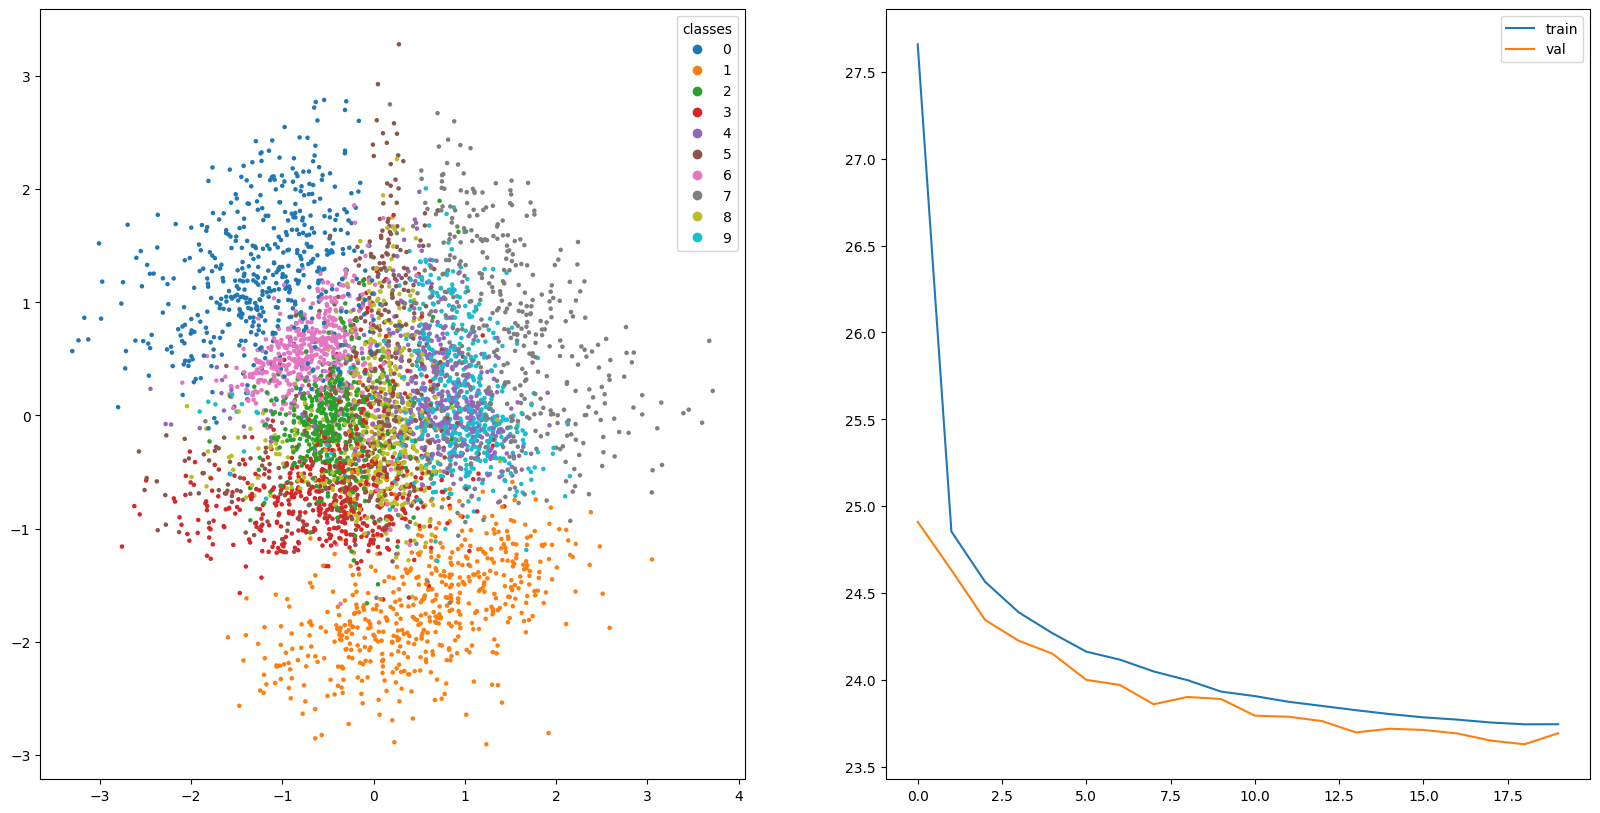

In [346]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

z = z.squeeze().cpu().detach()
sc = ax1.scatter(z[:, 0], z[:, 1], c=y_test, s=5, cmap='tab10')
ax1.legend(*sc.legend_elements(), title='classes')

ax2.plot(train_history, label="train")
ax2.plot(val_history, label="val")
ax2.legend()

### Generating samples

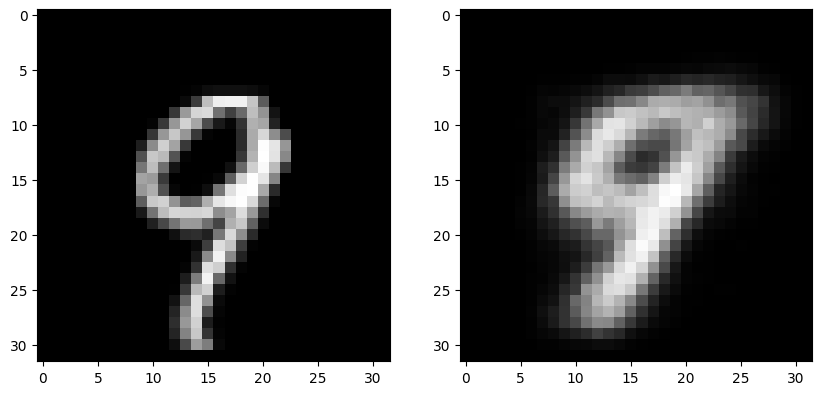

In [347]:
idx = 11
X_sample = X_test[idx].unsqueeze(1).to('cuda')

y_pred, _, _, _ = generator(X_sample)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(X_test[idx][None, :].squeeze(), cmap='gray')
ax2.imshow(F.sigmoid(y_pred).cpu().squeeze().detach(), cmap='gray')
plt.show()

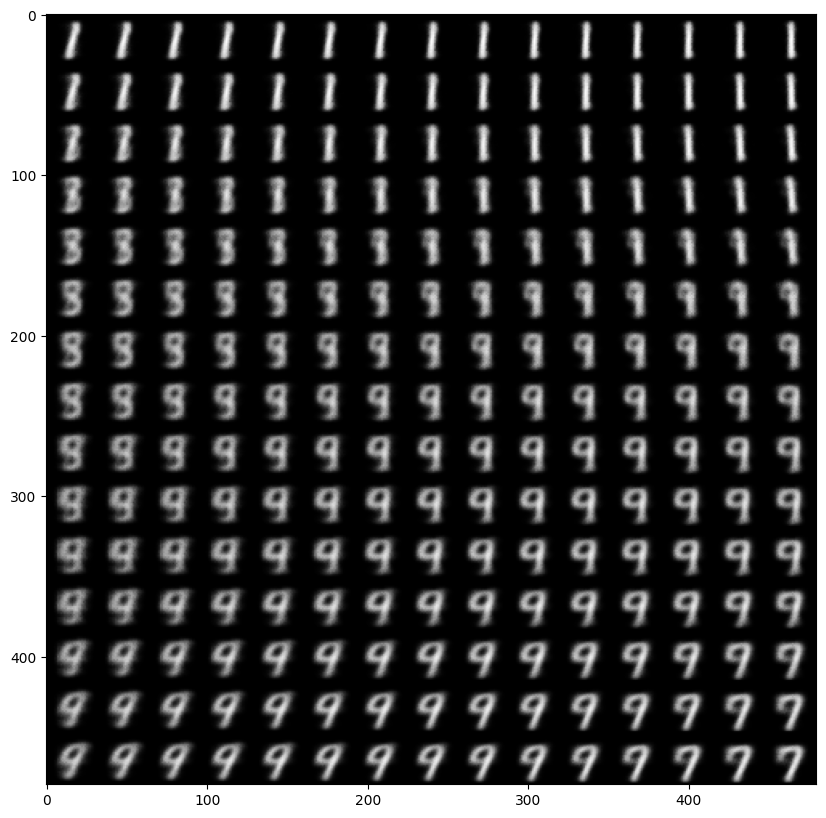

In [348]:
h, w = 15, 15
z1_range = torch.linspace(25, 75, h)
z2_range = torch.linspace(-75, 25, w)

z1, z2 = torch.meshgrid(z1_range, z2_range)
zz = torch.stack([z1, z2], dim=-1).reshape(-1, 2, 1, 1).to('cuda')

y_preds = F.sigmoid(generator.dec(zz)).squeeze().cpu().detach()
y_preds = y_preds.reshape(h, w, 32, 32).permute(1, 2, 0, 3).reshape(h*32, -1)

plt.figure(figsize=(10, 10))
plt.imshow(y_preds, cmap='gray')

## Another VAE example 

In [33]:
import scipy.io
mat = scipy.io.loadmat('../datasets/olivettifaces.mat')

### train/test/val split

In [250]:
dataset = (mat['faces'].T.reshape(-1, 1, 64, 64))
dataset = np.transpose(dataset, axes=(0, 1, 3, 2)).astype('float32')

dataset = (dataset - np.min(dataset))/np.ptp(dataset)

dataset = torch.tensor(dataset)
# test_val_set = (mat['u'].T.reshape(-1, 1, 64, 64))

# dataset = torch.tensor((dataset - np.mean(dataset, axis=(2, 3), keepdims=True)) / np.std(dataset, axis=(2, 3), keepdims=True)).type(torch.float32)
# dataset = transform(dataset)

# test_val_set = torch.tensor((test_val_set - np.mean(test_val_set, axis=(2, 3), keepdims=True)) / np.std(test_val_set, axis=(2, 3), keepdims=True)).type(torch.float32)
# test_val_set.transpose_(-2, -1)

mask = np.ones((dataset.shape[0]), bool)
idx = np.random.choice(dataset.shape[0], size=int(0.2 * dataset.shape[0]), replace=False)
mask[idx] = False

X_train = dataset[mask]
X_test = dataset[~mask][:idx.shape[0]//2]
X_val = dataset[~mask][idx.shape[0]//2:]

(X_train.shape, X_test.shape, X_val.shape)

(torch.Size([320, 1, 64, 64]),
 torch.Size([40, 1, 64, 64]),
 torch.Size([40, 1, 64, 64]))

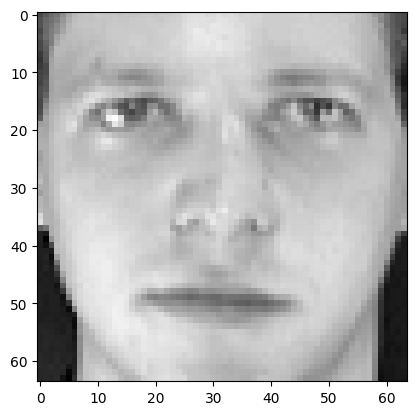

In [251]:
plt.imshow(X_train[0].squeeze(), cmap='gray')

### add extra encoder/decoder layer for 64 x 64 images

In [208]:
class Encoder64x64(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.net = nn.Sequential(
            # 64 -> 32
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 32 -> 16
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            # 16 -> 8
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            # 8 -> 4
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.ReLU(inplace=True),
            # 4 -> 1
            nn.Conv2d(512, z_size, kernel_size=3, stride=2, padding=0, bias=False),
        )
    
    def forward(self, X: torch.Tensor):
        return self.net(X)

class Decoder64x64(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.net = nn.Sequential(
            # 1 -> 4
            nn.ConvTranspose2d(z_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.ReLU(inplace=True),
            # 4 -> 8
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            # 8 -> 16
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            # 16 -> 32
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 32 -> 64
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
        )

    def forward(self, X: torch.Tensor):
        return self.net(X)
    
enc = Encoder64x64(2)
dec = Decoder64x64(2)
x = torch.randn(16, 1, 64, 64)
dec(enc(x)).shape

torch.Size([16, 1, 64, 64])

In [209]:
class VAE64x64(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.enc = Encoder64x64(2*z_size)
        self.dec = Decoder64x64(z_size)
    
    def encode(self, X: torch.Tensor):
        h = self.enc(X) # (batch_size, 2*z_dim, 1, 1)
        mu = h[:, :self.z_size].view(-1, self.z_size)       # mean vec mu: (batch_size, z_dim)
        log_var = h[:, self.z_size:].view(-1, self.z_size)  # log variance:(batch_size, z_dim)
        return mu, log_var
    
    def decode(self, mu: torch.Tensor, log_var: torch.Tensor):
        eps = torch.randn(mu.shape[0], self.z_size).to(mu.device) # random eps \sim N(0, I)
        z = mu + torch.exp(0.5 * log_var) * eps
        z = z.reshape(*z.shape, 1, 1) # (batch_size, z_dim, 1, 1)
        y = self.dec(z)
        return y, z
    
    def forward(self, X: torch.Tensor):
        mu, log_var = self.encode(X)
        y, z = self.decode(mu, log_var)
        return y, z, mu, log_var
    
x = torch.randn(16, 1, 64, 64)
g = VAE64x64(z_size=2)
y, z, mu, log_var = g(x)
y.shape, z.shape, mu.shape, log_var.shape

(torch.Size([16, 1, 64, 64]),
 torch.Size([16, 2, 1, 1]),
 torch.Size([16, 2]),
 torch.Size([16, 2]))

### Training procedure

In [317]:
EPOCHS = 100
Z_SIZE = 2
lambda_rec_error = 1000

train_loader = torch.utils.data.DataLoader(X_train, batch_size=8, shuffle=True)

generator = VAE64x64(z_size=Z_SIZE).to('cuda')

optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
criterion = nn.BCEWithLogitsLoss()

train_history = []
val_history = []

for epoch in range(EPOCHS):
    batch_history = []
    for i, images in enumerate(train_loader):
        images = images.to('cuda')
        # predict and compute loss
        preds, _, mu, log_var = generator(images)
        
        # from the original VAE paper
        kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
        rec_error = lambda_rec_error * criterion(preds, images)
        loss = rec_error + kl_reg
        
        batch_history.append(loss.item())
        # optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # update learning rate
    scheduler.step()
    
    train_history.append(torch.mean(torch.tensor(batch_history)))

    with torch.no_grad():
        preds, _, mu, log_var = generator(X_val.to('cuda'))
        kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
        rec_error = lambda_rec_error * criterion(preds, X_val.to('cuda'))
        loss = rec_error + kl_reg
        val_history.append(loss.item())
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")

with torch.no_grad():
    preds, z, mu, sigma = generator(X_test.to('cuda'))
    kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
    rec_error = lambda_rec_error * criterion(preds, X_test.to('cuda'))
    loss = rec_error + kl_reg
    print(f"test_loss {loss.item()}")

epoch 0, train_loss 728.32861328125, val_loss 697.404296875
epoch 1, train_loss 678.8284301757812, val_loss 683.1293334960938
epoch 2, train_loss 669.2101440429688, val_loss 677.3701782226562
epoch 3, train_loss 665.0338134765625, val_loss 677.4835205078125
epoch 4, train_loss 662.3800048828125, val_loss 673.7244873046875
epoch 5, train_loss 660.7258911132812, val_loss 675.0357055664062
epoch 6, train_loss 660.5160522460938, val_loss 672.9893798828125
epoch 7, train_loss 659.8724365234375, val_loss 674.8200073242188
epoch 8, train_loss 658.9904174804688, val_loss 673.6527099609375
epoch 9, train_loss 659.3338623046875, val_loss 676.3419189453125
epoch 10, train_loss 659.0821533203125, val_loss 673.74560546875
epoch 11, train_loss 657.8065795898438, val_loss 675.5359497070312
epoch 12, train_loss 658.1473388671875, val_loss 675.4846801757812
epoch 13, train_loss 658.06787109375, val_loss 670.8236083984375
epoch 14, train_loss 657.8469848632812, val_loss 672.506591796875
epoch 15, train_

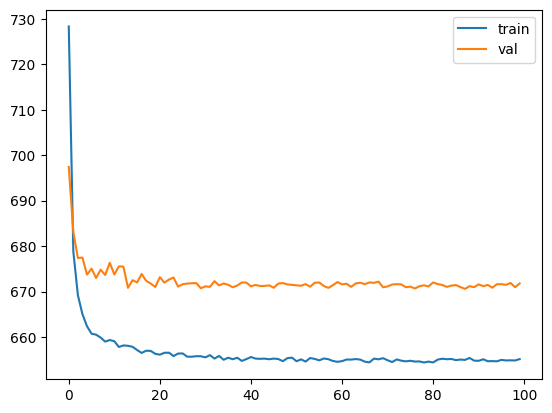

In [318]:
plt.plot(train_history, label="train")
plt.plot(val_history, label="val")
plt.legend()

### encoding decoding specific face 

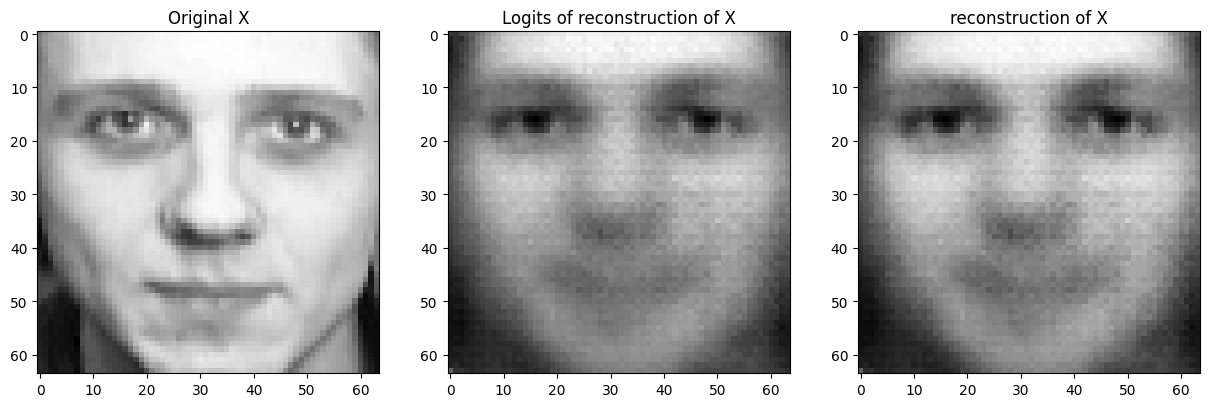

In [319]:
idx = 21
X_sample = X_test[idx].unsqueeze(1).to('cuda')

y_pred, _, _, _ = generator(X_sample)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(X_sample.cpu().squeeze(), cmap='gray')
ax1.set_title("Original X")

ax2.imshow(y_pred.cpu().squeeze().detach(), cmap='gray')
ax2.set_title("Logits of reconstruction of X")

ax3.imshow(F.sigmoid(y_pred).cpu().squeeze().detach(), cmap='gray')
ax3.set_title("reconstruction of X")

plt.show()

### sampling on the $z$-dimension manifold

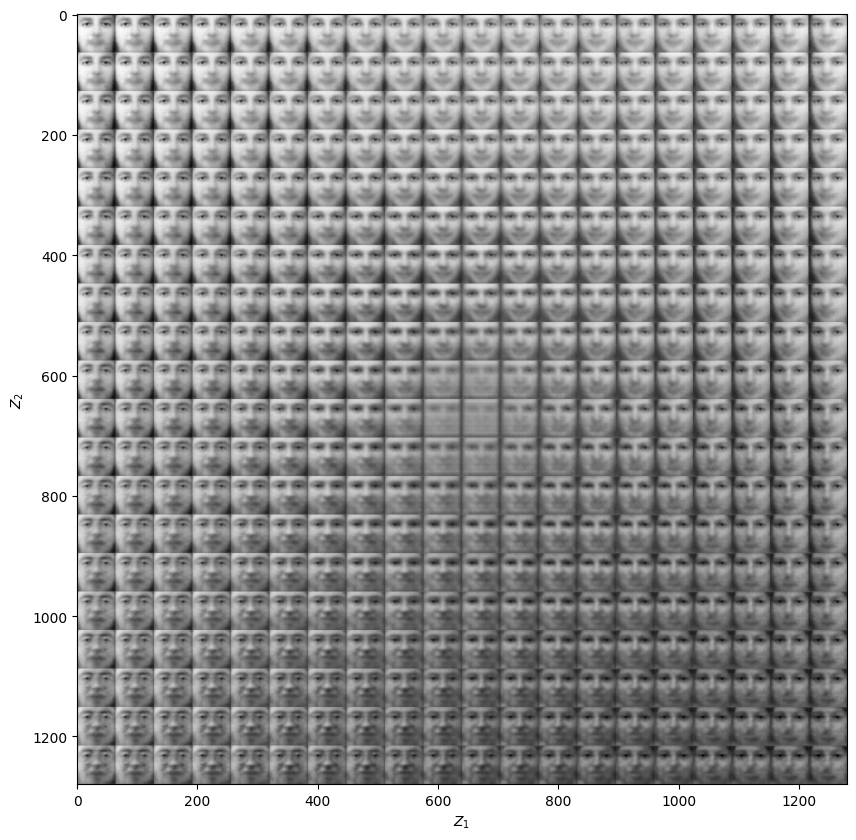

In [338]:
h, w = 20, 20
z1_range = torch.linspace(-1000, 1000, h)
z2_range = torch.linspace(-1000, 1000, w)

z1, z2 = torch.meshgrid(z1_range, z2_range)
zz = torch.stack([z1, z2], dim=-1).reshape(-1, 2, 1, 1).to('cuda')

y_preds = F.sigmoid(generator.dec(zz)).squeeze().cpu().detach()
y_preds = y_preds.reshape(h, w, 64, 64).permute(1, 2, 0, 3).reshape(h*64, -1)

plt.figure(figsize=(10, 10))
plt.imshow(y_preds, cmap='gray')
plt.axis('image')
plt.xlabel(r'$Z_1$')
plt.ylabel(r'$Z_2$')

# plt.savefig("../images/manifolds/faces.svg", dpi=300)

### random sampling if $z > 2$

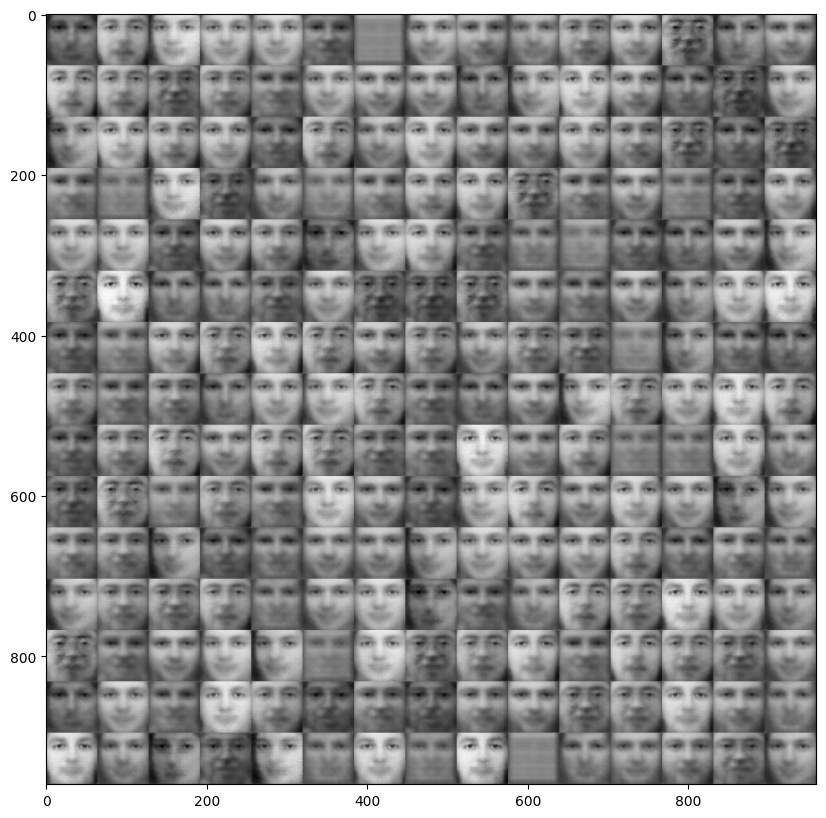

In [343]:
# h, w = 15, 15
# z_vecs = torch.randn(h*w, Z_SIZE, 1, 1).to('cuda')
# 
# y_preds = F.sigmoid(generator.dec(z_vecs)).squeeze().cpu().detach()
# y_preds = y_preds.reshape(h, w, 64, 64).permute(1, 2, 0, 3).reshape(h*64, -1)
# 
# plt.figure(figsize=(10, 10))
# plt.imshow(y_preds, cmap='gray')